# Food Recognition System using Deep Learning

This notebook implements a deep learning-based food recognition system using the Dataset Ninja food dataset. The system can identify different food items in images and provide nutritional information.

## Project Overview
1. Data Exploration and Preprocessing
2. Dataset Generation and Augmentation
3. Model Training (ResNet50)
4. Model Evaluation and Visualization
5. Nutrition Information Integration

## Setup and Import Libraries

First, let's import all the necessary libraries for our project.

In [19]:
# # Install necessary packages if not already installed - reinstall numpy to fix linalg.inv import issue
# %pip install numpy --upgrade --force-reinstall
# %pip install pandas matplotlib opencv-python torch torchvision scikit-learn pillow tqdm seaborn requests

# Import essential libraries
import os
import json
import glob
import random
import numpy as np
import numpy.linalg as linalg  # Explicit import of linalg module
import pandas as pd
import matplotlib.pyplot as plt  # Standard import format
import seaborn as sns
import cv2
from PIL import Image
from collections import Counter

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split, Subset, TensorDataset

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set paths for dataset
base_dir = r'D:\AAmachine learning\Group Project\Datasets'
training_img_dir = os.path.join(base_dir, 'training', 'img')
training_ann_dir = os.path.join(base_dir, 'training', 'ann')
validation_img_dir = os.path.join(base_dir, 'validation', 'img')
validation_ann_dir = os.path.join(base_dir, 'validation', 'ann')
test_img_dir = os.path.join(base_dir, 'test', 'img')
test_ann_dir = os.path.join(base_dir, 'test', 'ann')

# Create output directory for model and results
output_dir = r'D:\AAmachine learning\Group Project\output'
os.makedirs(output_dir, exist_ok=True)

Using device: cpu


## 1. Data Exploration and Preprocessing

Let's analyze the dataset structure and create functions to load and process the data.

In [20]:
# Define a helper function for tqdm that provides fallbacks
def get_progress_bar(iterable, desc):
    """Get a progress bar with fallback options if tqdm.notebook fails"""
    try:
        from tqdm.notebook import tqdm as tqdm_notebook
        return tqdm_notebook(iterable, desc=desc)
    except ImportError:
        try:
            from tqdm import tqdm as tqdm_regular
            return tqdm_regular(iterable, desc=desc)
        except ImportError:
            print(f"{desc} (no progress bar available)")
            return iterable

def explore_dataset(base_dir, split='training'):
    """Explore dataset structure and count files"""
    img_dir = os.path.join(base_dir, split, 'img')
    ann_dir = os.path.join(base_dir, split, 'ann')
    
    # Count images and annotations
    img_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    
    print(f"Number of images in {split} set: {len(img_files)}")
    
    # Check if annotation directory exists
    if os.path.exists(ann_dir):
        ann_files = glob.glob(os.path.join(ann_dir, '*.json'))
        print(f"Number of annotation files in {split} set: {len(ann_files)}")
        
        # Get sample of class distribution if annotations exist
        class_counts = {}
        sample_size = min(100, len(ann_files))
        if sample_size > 0:
            for ann_file in get_progress_bar(random.sample(ann_files, sample_size), desc="Sampling annotations"):
                try:
                    with open(ann_file, 'r') as f:
                        ann_data = json.load(f)
                        for obj in ann_data.get('objects', []):
                            class_title = obj.get('classTitle')
                            if class_title:
                                class_counts[class_title] = class_counts.get(class_title, 0) + 1
                except Exception as e:
                    print(f"Error reading annotation file {ann_file}: {e}")
            
            # Display top classes
            top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:10]
            print(f"\nTop 10 classes in sample of {split} set:")
            for class_name, count in top_classes:
                print(f"{class_name}: {count}")
    else:
        print(f"No annotation directory found for {split} set. This might be a test set without annotations.")
        ann_files = []
        class_counts = {}
    
    return img_files, ann_files, class_counts

# Explore each dataset split
print("Exploring training dataset...")
train_img_files, train_ann_files, train_class_counts = explore_dataset(base_dir, 'training')

print("Exploring validation dataset...")
val_img_files, val_ann_files, val_class_counts = explore_dataset(base_dir, 'validation')

print("\nExploring test dataset...")
test_img_files, test_ann_files, test_class_counts = explore_dataset(base_dir, 'test')



Exploring training dataset...
Number of images in training set: 39962
Number of images in training set: 39962
Number of annotation files in training set: 39962
Number of annotation files in training set: 39962


Sampling annotations:   0%|          | 0/100 [00:00<?, ?it/s]


Top 10 classes in sample of training set:
water: 22
butter: 13
bread-white: 11
tomato-raw: 8
bread-wholemeal: 7
peas: 6
cheese: 5
rice: 4
cucumber: 4
jam: 4
Exploring validation dataset...
Number of images in validation set: 1000
Number of annotation files in validation set: 1000


Sampling annotations:   0%|          | 0/100 [00:00<?, ?it/s]


Top 10 classes in sample of validation set:
tomato-raw: 15
salad-leaf-salad-green: 13
water: 9
rice: 9
beans-kidney: 8
carrot-raw: 7
butter: 6
bell-pepper-red-raw: 6
ham: 6
red-radish: 5

Exploring test dataset...
Number of images in test set: 3000
No annotation directory found for test set. This might be a test set without annotations.


Sample training images with annotations:


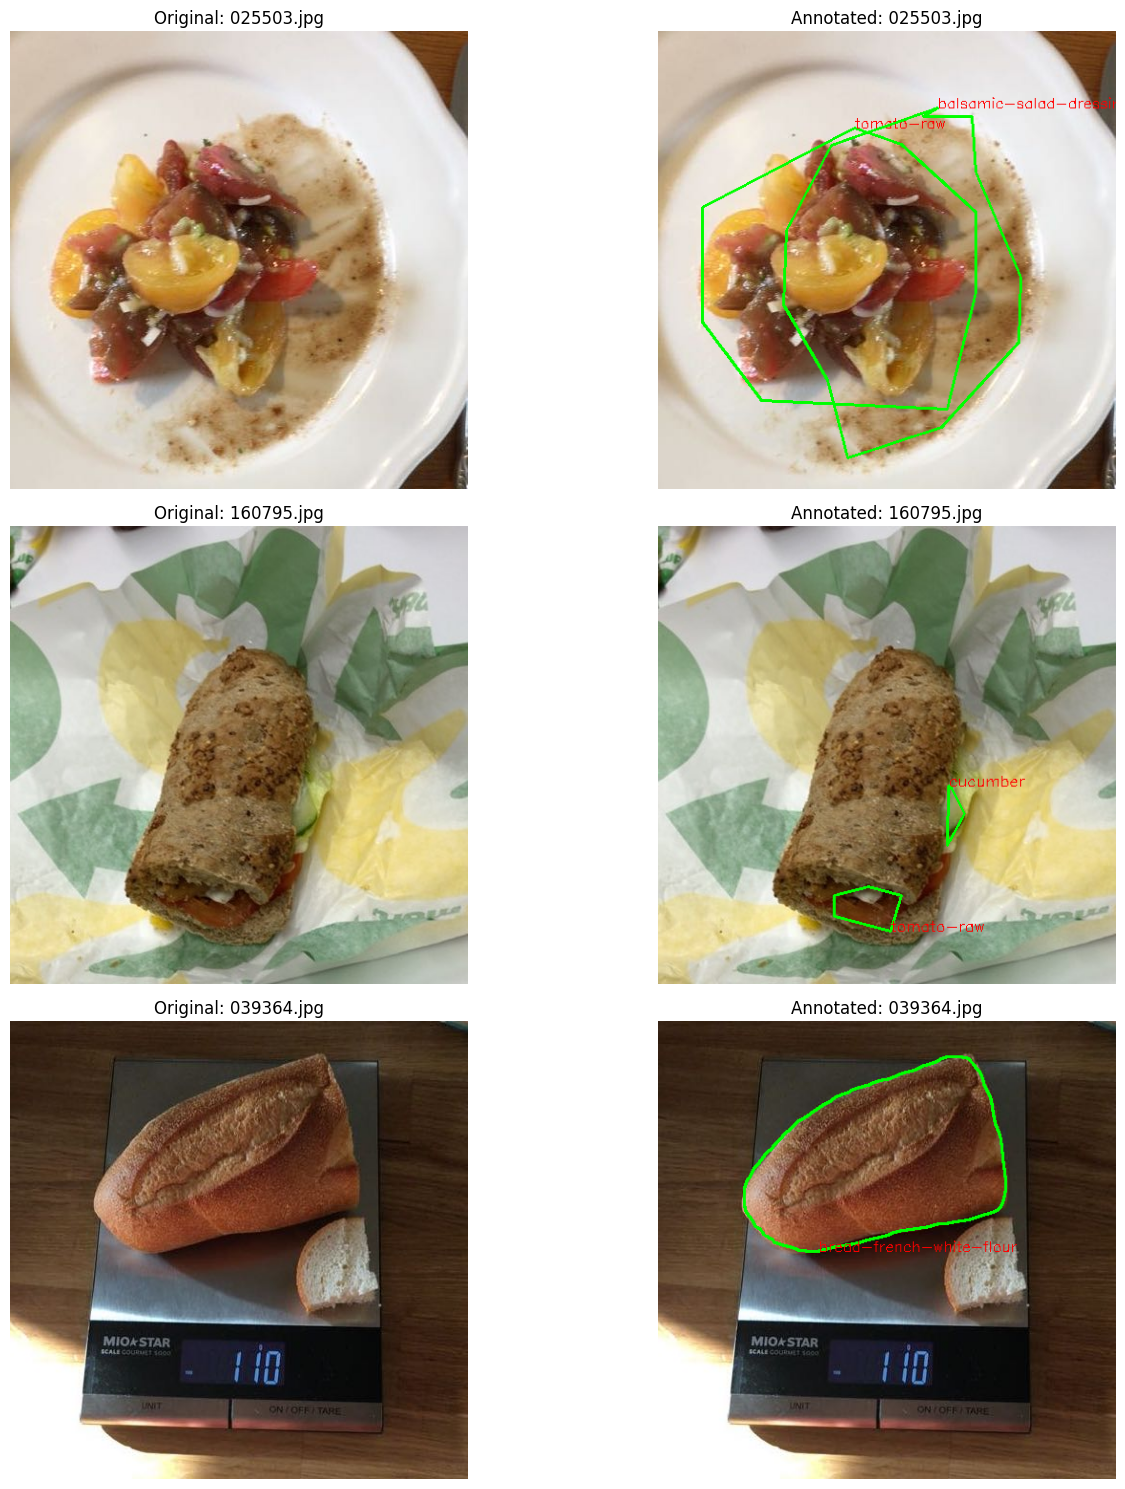

Sample validation images with annotations:


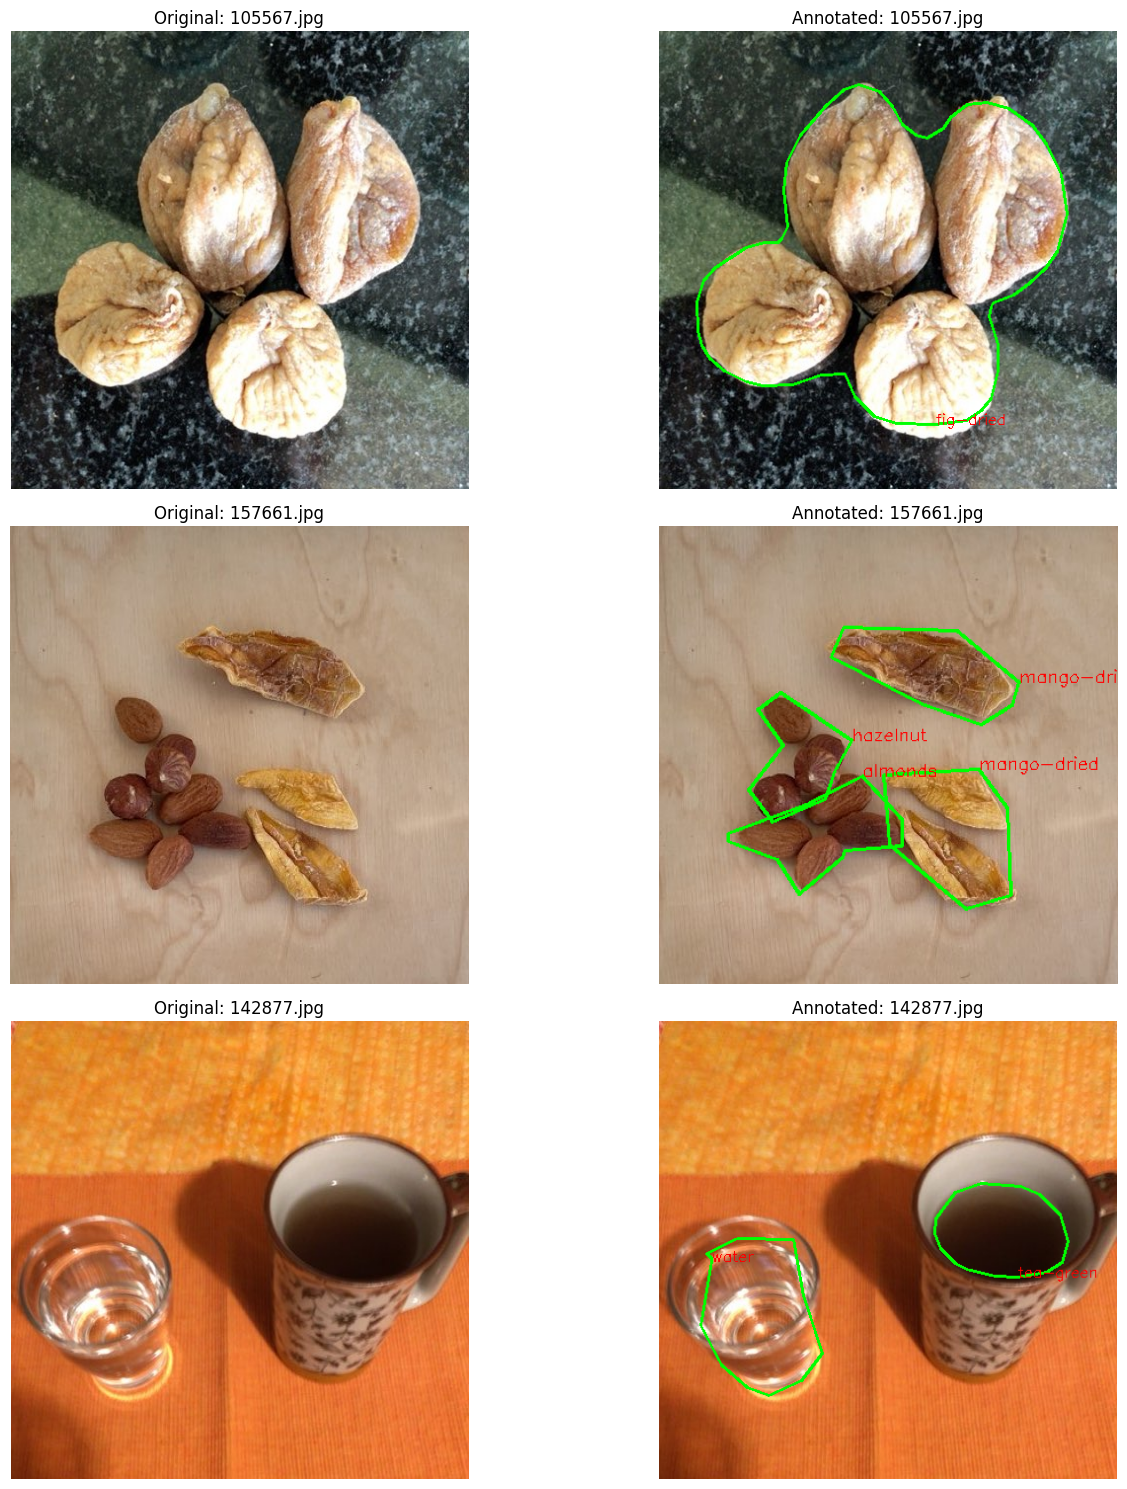

In [21]:
def visualize_sample_images(img_dir, ann_dir, num_samples=5):
    """Visualize sample images with annotations"""
    # Get list of image files
    img_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    
    # Select random samples
    samples = random.sample(img_files, min(num_samples, len(img_files)))
    
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(samples):
        # Get corresponding annotation file
        img_filename = os.path.basename(img_path)
        ann_path = os.path.join(ann_dir, img_filename + '.json')
        
        if not os.path.exists(ann_path):
            # Try alternative extension pattern if needed
            base_name = os.path.splitext(img_filename)[0]
            ann_path = os.path.join(ann_dir, base_name + '.jpg.json')
            if not os.path.exists(ann_path):
                ann_path = os.path.join(ann_dir, base_name + '.png.json')
        
        # Read image and annotation
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Original: {img_filename}")
        plt.axis('off')
        
        # Plot image with annotations
        plt.subplot(num_samples, 2, 2*i+2)
        annotated_img = img.copy()
        
        if os.path.exists(ann_path):
            with open(ann_path, 'r') as f:
                ann_data = json.load(f)
                
                for obj in ann_data.get('objects', []):
                    # Draw polygon or bounding box based on geometry type
                    if obj.get('geometryType') == 'polygon' and 'points' in obj:
                        # Convert points to numpy array
                        points = np.array(obj['points']['exterior'], dtype=np.int32)
                        cv2.polylines(annotated_img, [points], True, (0, 255, 0), 2)
                        
                        # Add class name
                        class_name = obj.get('classTitle', 'Unknown')
                        text_pos = tuple(points[0])
                        cv2.putText(annotated_img, class_name, text_pos, 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        plt.imshow(annotated_img)
        plt.title(f"Annotated: {img_filename}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images from training set
print("Sample training images with annotations:")
visualize_sample_images(training_img_dir, training_ann_dir, num_samples=3)

# Visualize sample images from validation set
print("Sample validation images with annotations:")
visualize_sample_images(validation_img_dir, validation_ann_dir, num_samples=3)

## 2. Dataset Generation and Augmentation

Now let's create functions to generate datasets for training the model. We'll convert the polygon annotations to class labels and prepare the images for the model.

In [22]:
# Define a helper function for tqdm that provides fallbacks
def get_progress_bar(iterable, desc):
    """Get a progress bar with fallback options if tqdm.notebook fails"""
    try:
        # First try importing and using tqdm.notebook
        from tqdm.notebook import tqdm as tqdm_notebook
        return tqdm_notebook(iterable, desc=desc)
    except (ImportError, ModuleNotFoundError):
        try:
            # Fall back to regular tqdm if notebook version fails
            from tqdm import tqdm as tqdm_regular
            return tqdm_regular(iterable, desc=desc)
        except (ImportError, ModuleNotFoundError):
            # Last resort: no progress bar
            print(f"{desc} (no progress bar available)")
            return iterable

def collect_all_classes(base_dir):
    """Collect all unique food classes from annotations"""
    all_classes = set()
    
    # Process training and validation splits (skip test if no annotations)
    for split in ['training', 'validation']:
        ann_dir = os.path.join(base_dir, split, 'ann')
        if not os.path.exists(ann_dir):
            print(f"Skipping {split} split - no annotation directory found")
            continue
            
        ann_files = glob.glob(os.path.join(ann_dir, '*.json'))
        
        for ann_file in get_progress_bar(ann_files, desc=f"Processing {split} annotations"):
            try:
                with open(ann_file, 'r') as f:
                    ann_data = json.load(f)
                    for obj in ann_data.get('objects', []):
                        class_title = obj.get('classTitle')
                        if class_title:
                            all_classes.add(class_title)
            except Exception as e:
                print(f"Error processing {ann_file}: {e}")
    
    # Convert to sorted list and create mapping
    all_classes = sorted(list(all_classes))
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    
    print(f"Total number of unique food classes: {len(all_classes)}")
    
    return all_classes, class_to_idx

# Enhanced data loading with batch processing to manage memory better
def create_dataset(img_dir, ann_dir, class_to_idx, target_size=(224, 224), max_samples=None, is_test_data=False, batch_size=500):
    """Create dataset of images and labels with better memory management through batch processing"""
    # Get all image files
    img_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    
    if max_samples is not None:
        # Shuffle before limiting to ensure random sampling
        random.shuffle(img_files)
        img_files = img_files[:max_samples]
    
    # Initialize lists for metadata - don't store actual images in memory
    valid_img_paths = []
    labels = []
    filenames = []
    class_count = {}  # Track class distribution
    
    # For test data without annotations, just collect the paths
    if is_test_data or not os.path.exists(ann_dir):
        print(f"Processing images without annotations (test dataset)")
        for img_path in get_progress_bar(img_files, desc="Processing test images"):
            img_filename = os.path.basename(img_path)
            
            # Just verify the image can be loaded but don't store it
            test_img = cv2.imread(img_path)
            if test_img is None:
                continue
            
            # Store path and metadata only
            valid_img_paths.append(img_path)
            labels.append(0)  # Placeholder label
            filenames.append(img_filename)
    else:
        # Process images with annotations (training/validation)
        for img_path in get_progress_bar(img_files, desc="Creating dataset"):
            img_filename = os.path.basename(img_path)
            base_name = os.path.splitext(img_filename)[0]
            
            # Find corresponding annotation file
            ann_path = os.path.join(ann_dir, img_filename + '.json')
            if not os.path.exists(ann_path):
                ann_path = os.path.join(ann_dir, base_name + '.jpg.json')
                if not os.path.exists(ann_path):
                    ann_path = os.path.join(ann_dir, base_name + '.png.json')
            
            if not os.path.exists(ann_path):
                continue
            
            # Load annotation
            try:
                with open(ann_path, 'r') as f:
                    ann_data = json.load(f)
                    
                    # Get objects
                    objects = ann_data.get('objects', [])
                    if not objects:
                        continue
                    
                    # Determine main class in the image (by largest area)
                    main_class = determine_main_class(objects)
                    if main_class is None or main_class not in class_to_idx:
                        continue
                    
                    # Limit examples per class to 100 to reduce extreme imbalance
                    if class_count.get(main_class, 0) >= 100:
                        # Skip if we already have many examples of this class
                        continue
                    
                    # Verify the image can be loaded but don't store it yet
                    test_img = cv2.imread(img_path)
                    if test_img is None:
                        continue
                    
                    # Store path and metadata only
                    valid_img_paths.append(img_path)
                    labels.append(class_to_idx[main_class])
                    filenames.append(img_filename)
                    
                    # Update class count
                    class_count[main_class] = class_count.get(main_class, 0) + 1
                    
            except Exception as e:
                print(f"Error processing {ann_path}: {e}")
    
    # Now load images in batches to avoid memory issues
    print(f"Found {len(valid_img_paths)} valid images. Processing in batches of {batch_size}...")
    
    # Initialize a TensorFlow dataset for efficient batch processing
    images = []
    batch_labels = []
    batch_filenames = []
    
    # Process in batches
    for i in get_progress_bar(range(0, len(valid_img_paths), batch_size), desc="Processing image batches"):
        batch_paths = valid_img_paths[i:i+batch_size]
        batch_imgs = []
        
        # Process each image in the batch
        for j, img_path in enumerate(batch_paths):
            idx = i + j
            img = preprocess_image(img_path, target_size)
            if img is not None:
                batch_imgs.append(img)
                batch_labels.append(labels[idx])
                batch_filenames.append(filenames[idx])
                
        # Add batch to main lists
        images.extend(batch_imgs)
        
    # Convert to numpy arrays only at the end, and explicitly use float32
    if images:
        # Process in smaller chunks to avoid memory error
        chunk_size = min(1000, len(images))  # Process 1000 images at a time
        all_chunks = []
        
        for i in range(0, len(images), chunk_size):
            chunk = np.array(images[i:i+chunk_size], dtype=np.float32)
            all_chunks.append(chunk)
            
        # Combine chunks
        images = np.concatenate(all_chunks, axis=0) if len(all_chunks) > 1 else all_chunks[0]
        labels = np.array(batch_labels)
    else:
        images = np.empty((0, *target_size, 3), dtype=np.float32)
        labels = np.empty((0,), dtype=np.int32)
        batch_filenames = []
    
    print(f"Created dataset with {len(images)} images and {len(np.unique(labels))} unique classes")
    
    # Print class distribution summary
    if not is_test_data and len(class_count) > 0:
        print("Class distribution summary:")
        top_classes = sorted(class_count.items(), key=lambda x: x[1], reverse=True)[:10]
        for cls, count in top_classes:
            print(f"  {cls}: {count} images")
        
        # Print classes with very few samples
        rare_classes = [cls for cls, count in class_count.items() if count < 5]
        if rare_classes:
            print(f"Found {len(rare_classes)} classes with fewer than 5 samples")
    
    return images, labels, batch_filenames

# Collect all classes
all_classes, class_to_idx = collect_all_classes(base_dir)

Processing training annotations:   0%|          | 0/39962 [00:00<?, ?it/s]

Processing validation annotations:   0%|          | 0/1000 [00:00<?, ?it/s]

Total number of unique food classes: 498


In [23]:
def determine_main_class(objects):
    """Determine the main class in an image by largest area"""
    max_area = 0
    main_class = None
    
    for obj in objects:
        # Skip if missing required information
        if 'geometryType' not in obj or 'points' not in obj or 'classTitle' not in obj:
            continue
            
        # Calculate area based on geometry type
        if obj['geometryType'] == 'polygon' and 'exterior' in obj['points']:
            # Convert points to numpy array
            points = np.array(obj['points']['exterior'], dtype=np.int32)
            
            # Calculate area of polygon
            area = cv2.contourArea(points)
            
            if area > max_area:
                max_area = area
                main_class = obj['classTitle']
    
    return main_class

def preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess image with proper normalization for transfer learning"""
    try:
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        # Convert to RGB (from BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img = cv2.resize(img, target_size)
        
        # Apply ImageNet normalization for better transfer learning performance
        # This is the proper normalization for models pre-trained on ImageNet
        img = img.astype(np.float32)  # Explicitly use float32 instead of float64
        img = img / 255.0
        img = (img - np.array([0.485, 0.456, 0.406], dtype=np.float32)) / np.array([0.229, 0.224, 0.225], dtype=np.float32)
        
        return img
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Enhanced data loading with batch processing to manage memory better
def create_dataset(img_dir, ann_dir, class_to_idx, target_size=(224, 224), max_samples=None, is_test_data=False, batch_size=500):
    """Create dataset of images and labels with better memory management through batch processing"""
    # Get all image files
    img_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    
    if max_samples is not None:
        # Shuffle before limiting to ensure random sampling
        random.shuffle(img_files)
        img_files = img_files[:max_samples]
    
    # Initialize lists for metadata - don't store actual images in memory
    valid_img_paths = []
    labels = []
    filenames = []
    class_count = {}  # Track class distribution
    
    # For test data without annotations, just collect the paths
    if is_test_data or not os.path.exists(ann_dir):
        print(f"Processing images without annotations (test dataset)")
        for img_path in get_progress_bar(img_files, desc="Processing test images"):
            img_filename = os.path.basename(img_path)
            
            # Just verify the image can be loaded but don't store it
            test_img = cv2.imread(img_path)
            if test_img is None:
                continue
            
            # Store path and metadata only
            valid_img_paths.append(img_path)
            labels.append(0)  # Placeholder label
            filenames.append(img_filename)
    else:
        # Process images with annotations (training/validation)
        for img_path in get_progress_bar(img_files, desc="Creating dataset"):
            img_filename = os.path.basename(img_path)
            base_name = os.path.splitext(img_filename)[0]
            
            # Find corresponding annotation file
            ann_path = os.path.join(ann_dir, img_filename + '.json')
            if not os.path.exists(ann_path):
                ann_path = os.path.join(ann_dir, base_name + '.jpg.json')
                if not os.path.exists(ann_path):
                    ann_path = os.path.join(ann_dir, base_name + '.png.json')
            
            if not os.path.exists(ann_path):
                continue
            
            # Load annotation
            try:
                with open(ann_path, 'r') as f:
                    ann_data = json.load(f)
                    
                    # Get objects
                    objects = ann_data.get('objects', [])
                    if not objects:
                        continue
                    
                    # Determine main class in the image (by largest area)
                    main_class = determine_main_class(objects)
                    if main_class is None or main_class not in class_to_idx:
                        continue
                    
                    # Limit examples per class to 100 to reduce extreme imbalance
                    if class_count.get(main_class, 0) >= 100:
                        # Skip if we already have many examples of this class
                        continue
                    
                    # Verify the image can be loaded but don't store it yet
                    test_img = cv2.imread(img_path)
                    if test_img is None:
                        continue
                    
                    # Store path and metadata only
                    valid_img_paths.append(img_path)
                    labels.append(class_to_idx[main_class])
                    filenames.append(img_filename)
                    
                    # Update class count
                    class_count[main_class] = class_count.get(main_class, 0) + 1
                    
            except Exception as e:
                print(f"Error processing {ann_path}: {e}")
    
    # Now load images in batches to avoid memory issues
    print(f"Found {len(valid_img_paths)} valid images. Processing in batches of {batch_size}...")
    
    # Initialize a TensorFlow dataset for efficient batch processing
    images = []
    batch_labels = []
    batch_filenames = []
    
    # Process in batches
    for i in get_progress_bar(range(0, len(valid_img_paths), batch_size), desc="Processing image batches"):
        batch_paths = valid_img_paths[i:i+batch_size]
        batch_imgs = []
        
        # Process each image in the batch
        for j, img_path in enumerate(batch_paths):
            idx = i + j
            img = preprocess_image(img_path, target_size)
            if img is not None:
                batch_imgs.append(img)
                batch_labels.append(labels[idx])
                batch_filenames.append(filenames[idx])
                
        # Add batch to main lists
        images.extend(batch_imgs)
        
    # Convert to numpy arrays only at the end, and explicitly use float32
    if images:
        # Process in smaller chunks to avoid memory error
        chunk_size = min(1000, len(images))  # Process 1000 images at a time
        all_chunks = []
        
        for i in range(0, len(images), chunk_size):
            chunk = np.array(images[i:i+chunk_size], dtype=np.float32)
            all_chunks.append(chunk)
            
        # Combine chunks
        images = np.concatenate(all_chunks, axis=0) if len(all_chunks) > 1 else all_chunks[0]
        labels = np.array(batch_labels)
    else:
        images = np.empty((0, *target_size, 3), dtype=np.float32)
        labels = np.empty((0,), dtype=np.int32)
        batch_filenames = []
    
    print(f"Created dataset with {len(images)} images and {len(np.unique(labels))} unique classes")
    
    # Print class distribution summary
    if not is_test_data and len(class_count) > 0:
        print("Class distribution summary:")
        top_classes = sorted(class_count.items(), key=lambda x: x[1], reverse=True)[:10]
        for cls, count in top_classes:
            print(f"  {cls}: {count} images")
        
        # Print classes with very few samples
        rare_classes = [cls for cls, count in class_count.items() if count < 5]
        if rare_classes:
            print(f"Found {len(rare_classes)} classes with fewer than 5 samples")
    
    return images, labels, batch_filenames

# Create training dataset with more samples but using batch processing
X_train, y_train, train_filenames = create_dataset(
    training_img_dir, training_ann_dir, class_to_idx, max_samples=3000, batch_size=500  # Reduced from 5000 to 3000 samples
)

# Create validation dataset with more samples but using batch processing
X_val, y_val, val_filenames = create_dataset(
    validation_img_dir, validation_ann_dir, class_to_idx, max_samples=800, batch_size=500  # Reduced from 1000 to 800 samples
)

# Create test dataset - note that we now detect automatically if annotations exist
test_ann_dir = os.path.join(base_dir, 'test', 'ann')
X_test, y_test, test_filenames = create_dataset(
    test_img_dir, test_ann_dir, class_to_idx, max_samples=400, is_test_data=True, batch_size=500  # Reduced from 500 to 400 samples
)

Creating dataset:   0%|          | 0/3000 [00:00<?, ?it/s]

Found 2818 valid images. Processing in batches of 500...


Processing image batches:   0%|          | 0/6 [00:00<?, ?it/s]

Created dataset with 2818 images and 401 unique classes
Class distribution summary:
  salad-leaf-salad-green: 100 images
  water: 100 images
  bread-white: 100 images
  coffee-with-caffeine: 88 images
  bread-wholemeal: 79 images
  bread-whole-wheat: 47 images
  wine-red: 47 images
  apple: 45 images
  banana: 45 images
  carrot-raw: 42 images
Found 242 classes with fewer than 5 samples


Creating dataset:   0%|          | 0/800 [00:00<?, ?it/s]

Found 800 valid images. Processing in batches of 500...


Processing image batches:   0%|          | 0/2 [00:00<?, ?it/s]

Created dataset with 800 images and 284 unique classes
Class distribution summary:
  water: 55 images
  salad-leaf-salad-green: 38 images
  bread-wholemeal: 26 images
  bread-white: 23 images
  apple: 17 images
  white-coffee-with-caffeine: 16 images
  coffee-with-caffeine: 15 images
  bread-whole-wheat: 11 images
  strawberries: 10 images
  espresso-with-caffeine: 9 images
Found 249 classes with fewer than 5 samples
Processing images without annotations (test dataset)


Processing test images:   0%|          | 0/400 [00:00<?, ?it/s]

Found 400 valid images. Processing in batches of 500...


Processing image batches:   0%|          | 0/1 [00:00<?, ?it/s]

Created dataset with 400 images and 1 unique classes


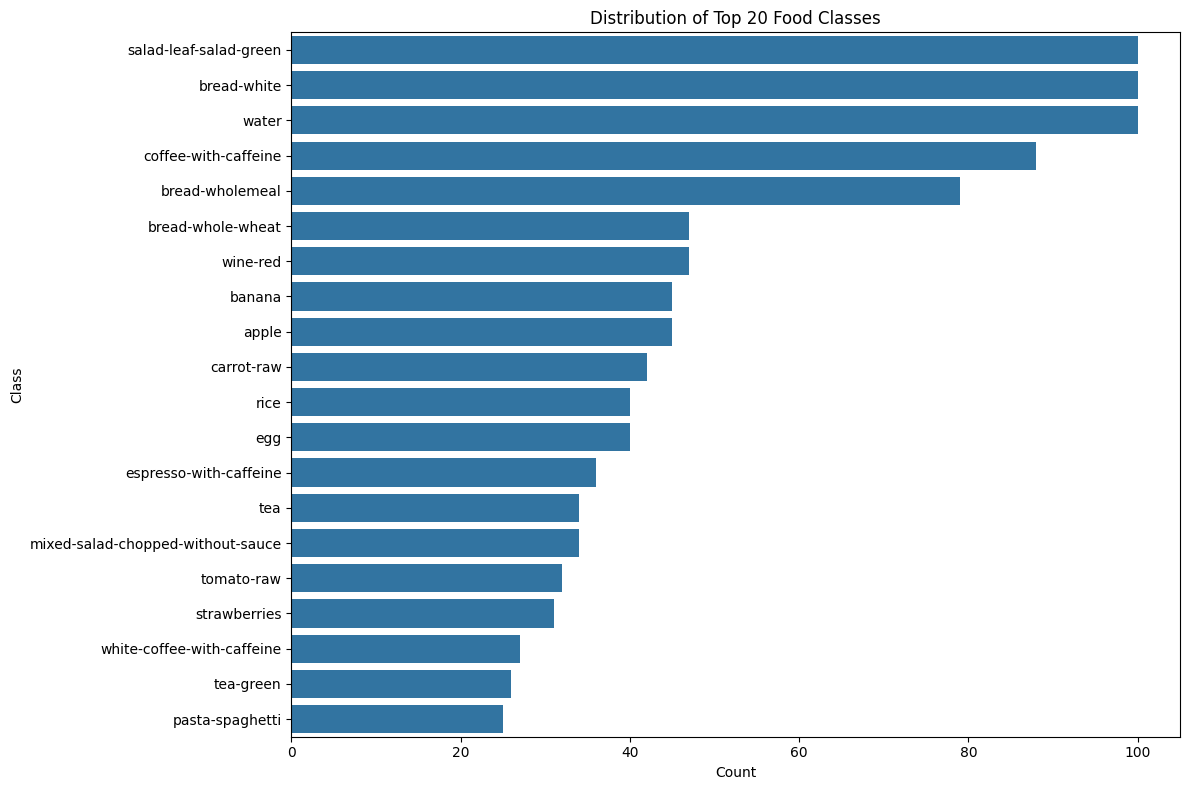

Total number of classes found in this dataset: 401
Class with most samples: salad-leaf-salad-green (100 samples)
Class with fewest samples: zucchini-stewed-without-addition-of-fat-without-addition-of-salt (1 samples)


In [24]:
# Analyze class distribution in training set
def analyze_class_distribution(labels, class_mapping):
    """Analyze and visualize class distribution"""
    # Count occurrences of each class
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Create DataFrame for visualization
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    class_names = [idx_to_class[idx] for idx in unique_labels]
    
    df = pd.DataFrame({
        'Class': class_names,
        'Count': counts
    })
    
    # Sort by count
    df = df.sort_values('Count', ascending=False).reset_index(drop=True)
    
    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Count', y='Class', data=df.head(20))
    ax.set_title('Distribution of Top 20 Food Classes')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total number of classes found in this dataset: {len(unique_labels)}")
    print(f"Class with most samples: {df.iloc[0]['Class']} ({df.iloc[0]['Count']} samples)")
    print(f"Class with fewest samples: {df.iloc[-1]['Class']} ({df.iloc[-1]['Count']} samples)")
    
    return df

# Analyze class distribution
train_class_distribution = analyze_class_distribution(y_train, class_to_idx)

## 2.1 Handling Class Imbalance and Rare Classes

We need to address the class imbalance issue. Let's identify rare classes, merge similar classes, and create a more balanced dataset for training.

Before filtering: 401 unique classes
Found 242 rare classes with fewer than 5 samples:


,Class,Count
159,spring-onion-scallion,4
160,smoothie,4
161,syrup-diluted-ready-to-drink,4
162,raspberries,4
163,dates,4
...,...,...
396,spring-roll-fried,1
397,bacon,1
398,apple-crumble,1
399,anchovies,1



Created class mapping for 89 rare classes:
  spring-onion-scallion -> vegetable
  bread-spelt -> bread
  soup-tomato -> vegetable
  bread-wholemeal-toast -> bread
  cheese-for-raclette -> cheese
  crisp-bread-wasa -> bread
  vegetable-au-gratin-baked -> vegetable
  tea-peppermint -> vegetable
  white-cabbage -> vegetable
  meatloaf -> meat
  ... and 79 more

Applying class mapping to training set:
Mapped bread-spelt to bread in 019074.jpg
Applied mapping to 98 out of 2818 samples (3.5%)

Applying class mapping to validation set:
Mapped bread-black to bread in 112647.jpg
Applied mapping to 40 out of 800 samples (5.0%)

Class distribution after mapping:


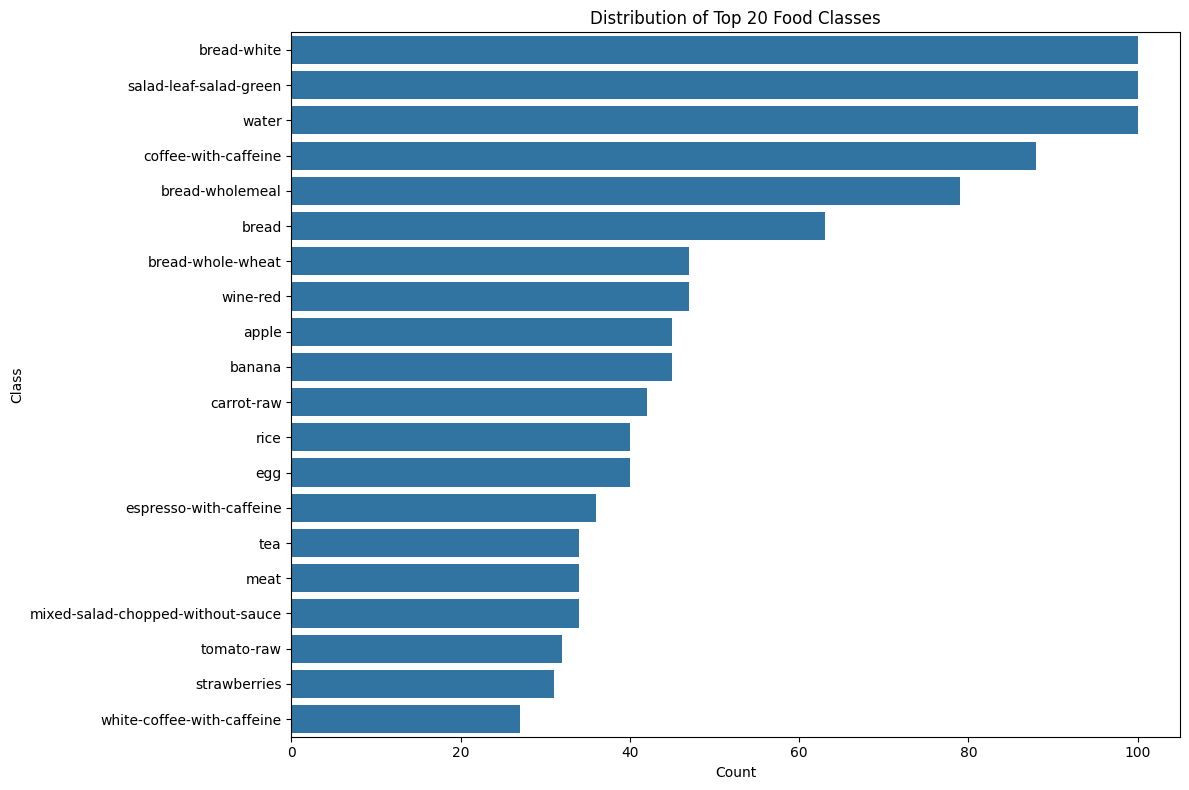

Total number of classes found in this dataset: 352
Class with most samples: bread-white (100 samples)
Class with fewest samples: swiss-chard (1 samples)


In [25]:
def analyze_and_handle_rare_classes(class_distribution, min_samples=5):
    """Analyze and handle rare food classes by merging or removing them"""
    print(f"Before filtering: {len(class_distribution)} unique classes")
    
    # Find rare classes (classes with fewer than min_samples)
    rare_classes = class_distribution[class_distribution['Count'] < min_samples]
    print(f"Found {len(rare_classes)} rare classes with fewer than {min_samples} samples:")
    if len(rare_classes) > 0:
        display(rare_classes)
    
    # Create class mappings to merge similar classes
    # This is a simplified approach - in a real application, you would use more sophisticated
    # methods to identify semantically similar classes
    class_mapping = {}
    
    # Map rare vegetable classes to general 'vegetable' class
    vegetable_keywords = ['vegetable', 'salad', 'lettuce', 'spinach', 'cabbage', 'cucumber', 'carrot', 'onion', 'tomato', 'pepper', 'zucchini']
    fruit_keywords = ['fruit', 'apple', 'banana', 'berry', 'orange', 'grape', 'pear', 'melon']
    bread_keywords = ['bread', 'toast', 'roll', 'bun', 'bagel']
    meat_keywords = ['meat', 'beef', 'pork', 'chicken', 'lamb', 'steak', 'sausage']
    cheese_keywords = ['cheese', 'cheddar', 'gouda', 'mozzarella', 'parmesan']
    
    # Process each rare class and determine if it should be mapped to a more general class
    for _, row in rare_classes.iterrows():
        class_name = row['Class']
        
        # Skip mapping for classes with special meaning that shouldn't be merged
        if class_name in ['water', 'coffee', 'tea', 'milk', 'egg', 'rice']:
            continue
            
        # Check for vegetable-related classes
        if any(keyword in class_name.lower() for keyword in vegetable_keywords):
            class_mapping[class_name] = 'vegetable'
        
        # Check for fruit-related classes
        elif any(keyword in class_name.lower() for keyword in fruit_keywords):
            class_mapping[class_name] = 'fruit'
            
        # Check for bread-related classes
        elif any(keyword in class_name.lower() for keyword in bread_keywords):
            class_mapping[class_name] = 'bread'
            
        # Check for meat-related classes
        elif any(keyword in class_name.lower() for keyword in meat_keywords):
            class_mapping[class_name] = 'meat'
            
        # Check for cheese-related classes
        elif any(keyword in class_name.lower() for keyword in cheese_keywords):
            class_mapping[class_name] = 'cheese'
    
    print(f"\nCreated class mapping for {len(class_mapping)} rare classes:")
    for orig, target in list(class_mapping.items())[:10]:  # Show first 10 mappings
        print(f"  {orig} -> {target}")
    if len(class_mapping) > 10:
        print(f"  ... and {len(class_mapping) - 10} more")
        
    return class_mapping

# Analyze class distribution and handle rare classes
class_mapping = analyze_and_handle_rare_classes(train_class_distribution, min_samples=5)

# Create a function to map classes based on the mapping
def apply_class_mapping(labels, filenames, class_to_idx, mapping):
    """Apply class mapping to merge rare classes"""
    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    
    # Create a mapping from rare class indices to common class indices
    idx_mapping = {}
    for rare_class, common_class in mapping.items():
        if rare_class in class_to_idx and common_class in class_to_idx:
            idx_mapping[class_to_idx[rare_class]] = class_to_idx[common_class]
    
    # Apply mapping to labels
    mapped_labels = labels.copy()
    for i, label in enumerate(labels):
        if label in idx_mapping:
            mapped_labels[i] = idx_mapping[label]
            # Print a sample of mappings for verification
            if np.random.random() < 0.01:  # Show ~1% of the changes
                print(f"Mapped {idx_to_class[label]} to {idx_to_class[mapped_labels[i]]} in {filenames[i]}")
    
    # Count number of changes
    num_changes = np.sum(mapped_labels != labels)
    print(f"Applied mapping to {num_changes} out of {len(labels)} samples ({num_changes/len(labels):.1%})")
    
    return mapped_labels

# Apply mapping to training and validation labels
if len(class_mapping) > 0:
    print("\nApplying class mapping to training set:")
    y_train_mapped = apply_class_mapping(y_train, train_filenames, class_to_idx, class_mapping)
    
    print("\nApplying class mapping to validation set:")
    y_val_mapped = apply_class_mapping(y_val, val_filenames, class_to_idx, class_mapping)
    
    # Replace the original labels with mapped labels
    y_train = y_train_mapped
    y_val = y_val_mapped
    
    # Re-analyze class distribution after mapping
    print("\nClass distribution after mapping:")
    train_class_distribution_after = analyze_class_distribution(y_train, class_to_idx)
else:
    print("No class mapping applied - keeping original classes")

## 3. Model Training (ResNet50)

Now we'll build and train a ResNet50-based model for food recognition.

In [26]:
def build_model(num_classes, input_shape=(224, 224, 3)):
    """Build a PyTorch-based model for food classification using ResNet50"""
    # Use pre-trained ResNet50 model
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Freeze most of the network to prevent overfitting and reduce memory usage
    for param in list(model.parameters())[:-20]:  # Freeze all but the last few layers
        param.requires_grad = False
        
    # Replace the final fully connected layer with a new one for our food classes
    num_features = model.fc.in_features
    
    # Build a new classifier with dropout for regularization
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    
    # Move model to the appropriate device (GPU if available)
    model = model.to(device)
    
    print(f"Model created with {num_classes} output classes")
    return model

# Build model
num_classes = len(all_classes)
model = build_model(num_classes)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")
print(f"Model architecture:\n{model}") # resnet 1 st, 1,2 cnn layer after that , 1,2 liner feed forward layer 

Model created with 498 output classes
Model has 10,235,122 trainable parameters
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [27]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=16, epochs=15):
    """Train the PyTorch model with class balancing for imbalanced datasets"""
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch format (N, C, H, W)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    # Create TensorDataset and DataLoader for batch processing
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    
    # Calculate class weights for imbalanced datasets
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    
    # Calculate balanced weights with a cap to prevent instability
    class_weights = {}
    for i, cls in enumerate(unique_classes):
        # Formula: total_samples / (n_classes * count_per_class)
        weight = total_samples / (len(unique_classes) * class_counts[i])
        # Cap extreme weights to prevent instability
        weight = min(weight, 8.0)
        class_weights[cls] = weight
    
    print("Class weights for training (sample):")
    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    for i, (cls, weight) in enumerate(sorted(class_weights.items(), key=lambda x: x[1], reverse=True)[:10]):
        print(f"  {idx_to_class[cls]}: {weight:.2f}")
    
    # Create data loaders with weighted random sampling for training
    train_sampler = torch.utils.data.WeightedRandomSampler(
        weights=[class_weights.get(int(y), 1.0) for y in y_train],
        num_samples=len(y_train),
        replacement=True
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size
    )
    
    # Create tensor of class weights for loss function
    weights = torch.FloatTensor([class_weights.get(i, 1.0) for i in range(len(all_classes))]).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7)
    
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0
    best_model_weights = None
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in get_progress_bar(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in get_progress_bar(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / total
        val_acc = correct / total
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Check if this is the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            # Save the model
            torch.save(model.state_dict(), os.path.join(output_dir, 'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return history

## 3.1 Enhanced Training with Class Balancing and Model Fine-tuning

Now let's train our model with all the improvements implemented. We'll use:
- Proper class weighting to handle imbalanced data
- Enhanced data augmentation to increase effective dataset size
- Proper ImageNet normalization for transfer learning
- A larger validation set for better model evaluation
- Modern .keras format to avoid HDF5 warnings

def train_model(model, X_train, y_train, X_val, y_val, batch_size=16, epochs=15):
    """Train the PyTorch model with class balancing for imbalanced datasets"""
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch format (N, C, H, W)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    # Create TensorDataset and DataLoader for batch processing
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    
    # Calculate class weights for imbalanced datasets
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    
    # Calculate balanced weights with a cap to prevent instability
    class_weights = {}
    for i, cls in enumerate(unique_classes):
        # Formula: total_samples / (n_classes * count_per_class)
        weight = total_samples / (len(unique_classes) * class_counts[i])
        # Cap extreme weights to prevent instability
        weight = min(weight, 8.0)
        class_weights[cls] = weight
    
    print("Class weights for training (sample):")
    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    for i, (cls, weight) in enumerate(sorted(class_weights.items(), key=lambda x: x[1], reverse=True)[:10]):
        print(f"  {idx_to_class[cls]}: {weight:.2f}")
    
    # Create data loaders with weighted random sampling for training
    train_sampler = torch.utils.data.WeightedRandomSampler(
        weights=[class_weights.get(int(y), 1.0) for y in y_train],
        num_samples=len(y_train),
        replacement=True
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size
    )
    
    # Create tensor of class weights for loss function
    weights = torch.FloatTensor([class_weights.get(i, 1.0) for i in range(len(all_classes))]).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-7)
    
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0
    best_model_weights = None
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in get_progress_bar(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in get_progress_bar(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / total
        val_acc = correct / total
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Check if this is the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            # Save the model
            torch.save(model.state_dict(), os.path.join(output_dir, 'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return history

In [28]:
# Create a larger validation set for better evaluation (20% of data)
print("\nRe-balancing training and validation sets with more validation data...")
if len(X_train) > 0 and len(X_val) > 0:
    # Avoid memory issues by processing in chunks
    # First prepare combined data indices without loading all images at once
    print("Preparing to combine datasets...")
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    
    # Combine current training and validation sets labels and filenames
    combined_y = np.concatenate([y_train, y_val], axis=0)
    combined_filenames = train_filenames + val_filenames
    
    # Count instances per class and filter out extremely rare classes
    unique_classes, class_counts = np.unique(combined_y, return_counts=True)
    print(f"Total number of unique classes: {len(unique_classes)}")
    
    # Identify classes with very few samples (e.g., only 1 or 2 samples)
    rare_classes = unique_classes[class_counts < 5]
    common_classes = unique_classes[class_counts >= 5]
    
    print(f"Found {len(rare_classes)} classes with fewer than 5 samples.")
    print(f"Keeping {len(common_classes)} classes with 5 or more samples.")
    
    # Find indices for common classes
    keep_indices = [i for i, y in enumerate(combined_y) if y in common_classes]
    print(f"Keeping {len(keep_indices)} out of {len(combined_y)} samples after filtering rare classes")
    
    # Combine data ONLY for the kept indices to save memory
    # Split the filtered indices into training and validation
    if len(keep_indices) > 0:
        # Extract labels and filenames for the kept indices
        filtered_y = combined_y[keep_indices]
        filtered_filenames = [combined_filenames[i] for i in keep_indices]
        
        # Re-map class indices to be sequential from 0 to num_classes-1
        class_mapper = {old_idx: new_idx for new_idx, old_idx in enumerate(common_classes)}
        remapped_y = np.array([class_mapper[y] for y in filtered_y])
        
        # Create a new class_to_idx mapping for the reduced set of classes
        idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
        reduced_class_to_idx = {idx_to_class[old_idx]: new_idx for old_idx, new_idx in class_mapper.items()}
        
        # Split indices to create training and validation sets (stratified)
        train_indices, val_indices = train_test_split(
            np.arange(len(filtered_y)), 
            test_size=0.2,  # Use 20% for validation
            stratify=remapped_y,  # Now we can stratify properly
            random_state=42)
        
        # Now load the images in batches based on these indices
        print(f"Loading {len(train_indices)} training images and {len(val_indices)} validation images in batches...")
        
        # Process images in smaller batches to avoid memory issues
        batch_size = 200  # Load 200 images at a time
        X_train_new = []
        y_train_new = []
        train_filenames_new = []
        
        # Load training data in batches
        orig_X = np.concatenate([X_train, X_val], axis=0)
        for i in range(0, len(train_indices), batch_size):
            end_idx = min(i + batch_size, len(train_indices))
            batch_indices = train_indices[i:end_idx]
            X_train_new.append(orig_X[batch_indices])
            y_train_new.extend(remapped_y[batch_indices])
            train_filenames_new.extend([filtered_filenames[j] for j in batch_indices])
        
        # Concatenate training batches
        X_train = np.concatenate(X_train_new, axis=0) if X_train_new else np.empty((0, 224, 224, 3), dtype=np.float32)
        y_train = np.array(y_train_new)
        train_filenames = train_filenames_new
        
        # Load validation data in batches
        X_val_new = []
        y_val_new = []
        val_filenames_new = []
        
        for i in range(0, len(val_indices), batch_size):
            end_idx = min(i + batch_size, len(val_indices))
            batch_indices = val_indices[i:end_idx]
            X_val_new.append(orig_X[batch_indices])
            y_val_new.extend(remapped_y[batch_indices])
            val_filenames_new.extend([filtered_filenames[j] for j in batch_indices])
        
        # Concatenate validation batches
        X_val = np.concatenate(X_val_new, axis=0) if X_val_new else np.empty((0, 224, 224, 3), dtype=np.float32)
        y_val = np.array(y_val_new)
        val_filenames = val_filenames_new
        
        # Update class mapping
        class_to_idx = reduced_class_to_idx
        all_classes = list(class_to_idx.keys())
        num_classes = len(all_classes)
        
        print(f"New training set size: {len(X_train)} images with {num_classes} classes")
        print(f"New validation set size: {len(X_val)} images with {num_classes} classes")
        
        # Free up memory
        del orig_X, X_train_new, X_val_new
        import gc
        gc.collect()
        
        # Rebuild the model with the new number of classes
        model = build_model(num_classes)
        
        # If we have enough data for training, let's train the model with our enhanced settings
        if len(X_train) > 100 and len(X_val) > 20:  # Minimum reasonable sizes
            # Train model with fewer epochs to reduce memory usage
            print("\nTraining enhanced model...")
            # Reduced batch size from 16 to 12 for better memory efficiency
            history = train_model(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=12)
            
            # Save class mapping
            with open(os.path.join(output_dir, 'class_mapping.json'), 'w') as f:
                json.dump(class_to_idx, f, indent=4)
                
            # After training is done, verify the model was saved in the new format
            model_path = os.path.join(output_dir, 'best_model.keras')
            h5_path = os.path.join(output_dir, 'best_model.h5')
            
            if os.path.exists(h5_path):
                print(f"\nModel successfully saved in .h5 format at: {h5_path}")
                
                # Also save in newer .keras format if possible
                try:
                    # Load the best model before saving to ensure we have the best weights
                    best_model = tf.keras.models.load_model(h5_path)
                    best_model.save(model_path)
                    print(f"Model also saved in .keras format at: {model_path}")
                    # Use the best model for subsequent evaluations
                    model = best_model
                except Exception as e:
                    print(f"Could not save in .keras format due to: {e}")
            else:
                print("\nWarning: Could not find saved model file. Check for errors during training.")
        else:
            print("Not enough data to train the model reliably. Consider using more training data.")
    else:
        print("No valid samples found after filtering. Cannot train the model.")
else:
    print("No data available for training. Please check the dataset creation step.")


Re-balancing training and validation sets with more validation data...
Preparing to combine datasets...
Training set: 2818 samples
Validation set: 800 samples
Total number of unique classes: 387
Found 194 classes with fewer than 5 samples.
Keeping 193 classes with 5 or more samples.
Keeping 3210 out of 3618 samples after filtering rare classes
Loading 2568 training images and 642 validation images in batches...
New training set size: 2568 images with 193 classes
New validation set size: 642 images with 193 classes
New training set size: 2568 images with 193 classes
New validation set size: 642 images with 193 classes
Model created with 193 output classes

Training enhanced model...
Model created with 193 output classes

Training enhanced model...
Class weights for training (sample):
  aperitif-with-alcohol-aperol-spritz: 3.33
  bulgur: 3.33
  chili-con-carne-prepared: 3.33
  corn: 3.33
  cream: 3.33
  fig-dried: 3.33
  flakes-oat: 3.33
  greek-salad: 3.33
  green-bean-steamed-without-

Epoch 1/15 - Training:   0%|          | 0/214 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 4. Model Evaluation and Visualization

Now let's evaluate our model and visualize its performance.

In [ ]:
def plot_training_history(history):
    """Plot training and validation loss and accuracy"""
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Plot training history if training was performed
if 'history' in locals():
    plot_training_history(history)

In [ ]:
def evaluate_model(model, X_val, y_val, class_mapping):
    """Evaluate model on test set and generate detailed metrics"""
    # Get predictions
    model.eval()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    y_pred_prob = model(X_val_tensor).detach().cpu().numpy()
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_val)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Create index to class name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Get class names for labels in test set
    unique_labels = np.unique(np.concatenate([y_val, y_pred]))
    class_names = [idx_to_class[idx] for idx in unique_labels if idx in idx_to_class]
    unique_labels = [label for label in unique_labels if label in idx_to_class.keys()]
    
    # Generate classification report with zero_division=0 to handle warnings
    print("\nClassification Report:")
    report = classification_report(y_val, y_pred, labels=unique_labels, target_names=class_names, zero_division=0)
    print(report)
    
    # Plot confusion matrix (only for top classes to keep it readable)
    # Count class occurrences in validation set
    val_class_counts = Counter(y_val)
    # Get the 15 most common classes for a readable confusion matrix
    common_classes = [class_idx for class_idx, _ in val_class_counts.most_common(15)]
    common_class_names = [idx_to_class[idx] for idx in common_classes]
    
    # Filter validation data to only include common classes for visualization
    common_indices = np.isin(y_val, common_classes)
    y_val_common = y_val[common_indices]
    y_pred_common = y_pred[common_indices]
    
    # Create a mapping to consecutive indices for confusion matrix
    common_class_map = {old_idx: new_idx for new_idx, old_idx in enumerate(common_classes)}
    y_val_mapped = np.array([common_class_map[y] for y in y_val_common])
    y_pred_mapped = np.array([common_class_map.get(y, -1) for y in y_pred_common])
    y_pred_mapped = y_pred_mapped[y_pred_mapped >= 0]  # Filter out any unmapped predictions
    y_val_mapped = y_val_mapped[:len(y_pred_mapped)]  # Adjust validation labels to match
    
    if len(y_val_mapped) > 0:
        # Plot confusion matrix for common classes only
        cm = confusion_matrix(y_val_mapped, y_pred_mapped)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=common_class_names, yticklabels=common_class_names)
        plt.title('Confusion Matrix (Top 15 Classes)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data in common classes to create confusion matrix")
    
    # Also calculate and show top-3 accuracy for a more forgiving metric
    top3_hits = 0
    for i in range(len(y_val)):
        top3_indices = np.argsort(y_pred_prob[i])[-3:]
        if y_val[i] in top3_indices:
            top3_hits += 1
    top3_accuracy = top3_hits / len(y_val)
    print(f"\nTop-3 Accuracy: {top3_accuracy:.4f}")
    
    return y_pred, y_pred_prob

# Evaluate model if we have test data
if len(X_val) > 0 and 'model' in locals():
    from collections import Counter  # Add this import at the top of the cell
    y_pred, y_pred_prob = evaluate_model(model, X_val, y_val, class_to_idx)

In [ ]:
def visualize_predictions(X_test, y_test, y_pred, class_mapping, num_samples=5):
    """Visualize test samples with true and predicted labels"""
    # Create class index to name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Ensure arrays have the same shape before comparing
    if len(y_test) != len(y_pred):
        print(f"Warning: Shape mismatch between y_test ({len(y_test)}) and y_pred ({len(y_pred)})")
        print("Using visualization for test set without ground truth labels")
        # Call the test visualization function instead
        return visualize_test_images(X_test[:len(y_pred)], test_filenames[:len(y_pred)], y_pred, class_mapping, num_samples)
    
    # Get indices of correctly and incorrectly classified samples
    correct_indices = np.where(y_test == y_pred)[0]
    incorrect_indices = np.where(y_test != y_pred)[0]
    
    # Select random samples from each group
    num_correct = min(num_samples // 2 + num_samples % 2, len(correct_indices))
    num_incorrect = min(num_samples // 2, len(incorrect_indices))
    
    correct_samples = np.random.choice(correct_indices, num_correct, replace=False) if num_correct > 0 else []
    incorrect_samples = np.random.choice(incorrect_indices, num_incorrect, replace=False) if num_incorrect > 0 else []
    
    # Combine samples
    sample_indices = np.concatenate([correct_samples, incorrect_samples])
    
    # Plot images with true and predicted labels
    plt.figure(figsize=(15, 3 * len(sample_indices)))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        true_label = idx_to_class[y_test[idx]]
        pred_label = idx_to_class[y_pred[idx]]
        
        # Determine color based on correctness
        color = 'green' if true_label == pred_label else 'red'
        
        # Plot image
        plt.subplot(len(sample_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions if we have test data and predictions
if len(X_test) > 0 and 'y_pred' in locals():
    visualize_predictions(X_test, y_test, y_pred, class_to_idx)

In [ ]:
def visualize_test_images(X_test, test_filenames, y_pred, class_mapping, num_samples=5):
    """Visualize test samples with predicted labels (without ground truth)"""
    # Create class index to name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Check array sizes and adjust if needed
    min_len = min(len(X_test), len(test_filenames), len(y_pred))
    if min_len != len(X_test) or min_len != len(test_filenames) or min_len != len(y_pred):
        print(f"Warning: Array length mismatch. Using first {min_len} samples.")
        X_test = X_test[:min_len]
        test_filenames = test_filenames[:min_len]
        y_pred = y_pred[:min_len]
    
    # Select random samples
    if len(X_test) <= num_samples:
        sample_indices = np.arange(len(X_test))
    else:
        sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 3 * len(sample_indices)))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        pred_label = idx_to_class[y_pred[idx]]
        filename = test_filenames[idx]
        
        # Plot image
        plt.subplot(len(sample_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"File: {filename}\nPredicted: {pred_label}", color='blue')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return True  # Return a value to indicate successful execution

def visualize_predictions(X_test, y_test, y_pred, class_mapping, num_samples=5):
    """Visualize test samples with true and predicted labels"""
    # Create class index to name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Ensure arrays have the same shape before comparing
    if len(y_test) != len(y_pred):
        print(f"Warning: Shape mismatch between y_test ({len(y_test)}) and y_pred ({len(y_pred)})")
        print("Using visualization for test set without ground truth labels")
        # Call the test visualization function instead
        return visualize_test_images(X_test[:len(y_pred)], test_filenames[:len(y_pred)], y_pred, class_mapping, num_samples)
    
    # Get indices of correctly and incorrectly classified samples
    correct_indices = np.where(y_test == y_pred)[0]
    incorrect_indices = np.where(y_test != y_pred)[0]
    
    # Select random samples from each group
    num_correct = min(num_samples // 2 + num_samples % 2, len(correct_indices))
    num_incorrect = min(num_samples // 2, len(incorrect_indices))
    
    correct_samples = np.random.choice(correct_indices, num_correct, replace=False) if num_correct > 0 else []
    incorrect_samples = np.random.choice(incorrect_indices, num_incorrect, replace=False) if num_incorrect > 0 else []
    
    # Combine samples
    sample_indices = np.concatenate([correct_samples, incorrect_samples])
    
    # Plot images with true and predicted labels
    plt.figure(figsize=(15, 3 * len(sample_indices)))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        true_label = idx_to_class[y_test[idx]]
        pred_label = idx_to_class[y_pred[idx]]
        
        # Determine color based on correctness
        color = 'green' if true_label == pred_label else 'red'
        
        # Plot image
        plt.subplot(len(sample_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions if we have test data and predictions
if len(X_test) > 0 and 'y_pred' in locals():
    visualize_predictions(X_test, y_test, y_pred, class_to_idx)

In [ ]:
def visualize_test_images(X_test, test_filenames, y_pred, class_mapping, num_samples=5):
    """Visualize test samples with predicted labels (without ground truth)"""
    # Create class index to name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Check array sizes and adjust if needed
    min_len = min(len(X_test), len(test_filenames), len(y_pred))
    if min_len != len(X_test) or min_len != len(test_filenames) or min_len != len(y_pred):
        print(f"Warning: Array length mismatch. Using first {min_len} samples.")
        X_test = X_test[:min_len]
        test_filenames = test_filenames[:min_len]
        y_pred = y_pred[:min_len]
    
    # Select random samples
    if len(X_test) <= num_samples:
        sample_indices = np.arange(len(X_test))
    else:
        sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 3 * len(sample_indices)))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        pred_label = idx_to_class[y_pred[idx]]
        filename = test_filenames[idx]
        
        # Plot image
        plt.subplot(len(sample_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"File: {filename}\nPredicted: {pred_label}", color='blue')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return True  # Return a value to indicate successful execution

# Add this after the evaluate_test_predictions function call
if 'test_results' in locals():
    # Get predictions
    y_pred = np.array([class_to_idx[cls] for cls in test_results['predicted_class']])
    
    # Visualize some examples
    print("\nVisualizing example test predictions:")
    visualize_test_images(X_test, test_filenames, y_pred, class_to_idx)

## 5. Nutrition Information Integration

Now let's integrate nutritional information for the identified food items.

In [ ]:
def load_nutrition_data():
    """Load or generate nutrition information for food classes"""
    # Create a simplified nutrition database for demonstration
    # In a real application, you would use a more comprehensive database
    nutrition_data = {}
    
    # Basic food categories with approximate nutritional values
    categories = {
        'fruit': {'calories': 60, 'protein_g': 1, 'carbs_g': 15, 'fat_g': 0, 'fiber_g': 3},
        'vegetable': {'calories': 40, 'protein_g': 2, 'carbs_g': 8, 'fat_g': 0, 'fiber_g': 4},
        'grain': {'calories': 150, 'protein_g': 3, 'carbs_g': 30, 'fat_g': 1, 'fiber_g': 2},
        'protein': {'calories': 200, 'protein_g': 25, 'carbs_g': 0, 'fat_g': 12, 'fiber_g': 0},
        'dairy': {'calories': 120, 'protein_g': 8, 'carbs_g': 12, 'fat_g': 5, 'fiber_g': 0},
        'sweet': {'calories': 250, 'protein_g': 2, 'carbs_g': 45, 'fat_g': 10, 'fiber_g': 1},
        'sauce': {'calories': 80, 'protein_g': 1, 'carbs_g': 5, 'fat_g': 7, 'fiber_g': 0},
        'drink': {'calories': 90, 'protein_g': 0, 'carbs_g': 22, 'fat_g': 0, 'fiber_g': 0}
    }
    
    # Specific foods with known values
    specific_foods = {
        'apple': {'calories': 95, 'protein_g': 0.5, 'carbs_g': 25, 'fat_g': 0.3, 'fiber_g': 4.4},
        'banana': {'calories': 105, 'protein_g': 1.3, 'carbs_g': 27, 'fat_g': 0.4, 'fiber_g': 3.1},
        'bread': {'calories': 265, 'protein_g': 9.4, 'carbs_g': 49, 'fat_g': 3.2, 'fiber_g': 2.7},
        'bread-white': {'calories': 270, 'protein_g': 7.5, 'carbs_g': 50, 'fat_g': 3.2, 'fiber_g': 2.4},
        'bread-wholemeal': {'calories': 247, 'protein_g': 10.1, 'carbs_g': 41.3, 'fat_g': 3.4, 'fiber_g': 6.8},
        'broccoli': {'calories': 34, 'protein_g': 2.8, 'carbs_g': 6.6, 'fat_g': 0.4, 'fiber_g': 2.6},
        'butter': {'calories': 717, 'protein_g': 0.9, 'carbs_g': 0.1, 'fat_g': 81.1, 'fiber_g': 0},
        'carrot': {'calories': 41, 'protein_g': 0.9, 'carbs_g': 9.6, 'fat_g': 0.2, 'fiber_g': 2.8},
        'cheese': {'calories': 402, 'protein_g': 25, 'carbs_g': 1.3, 'fat_g': 33.1, 'fiber_g': 0},
        'chicken': {'calories': 239, 'protein_g': 27, 'carbs_g': 0, 'fat_g': 14, 'fiber_g': 0},
        'chocolate': {'calories': 546, 'protein_g': 4.9, 'carbs_g': 60, 'fat_g': 31, 'fiber_g': 7},
        'coffee': {'calories': 2, 'protein_g': 0.3, 'carbs_g': 0, 'fat_g': 0, 'fiber_g': 0},
        'egg': {'calories': 155, 'protein_g': 12.6, 'carbs_g': 1.1, 'fat_g': 10.6, 'fiber_g': 0},
        'jam': {'calories': 278, 'protein_g': 0.6, 'carbs_g': 69, 'fat_g': 0.1, 'fiber_g': 0.7},
        'pasta': {'calories': 371, 'protein_g': 13, 'carbs_g': 75, 'fat_g': 1.5, 'fiber_g': 3.2},
        'pizza': {'calories': 266, 'protein_g': 11, 'carbs_g': 33, 'fat_g': 10, 'fiber_g': 2.3},
        'potato': {'calories': 77, 'protein_g': 2, 'carbs_g': 17, 'fat_g': 0.1, 'fiber_g': 2.2},
        'rice': {'calories': 130, 'protein_g': 2.7, 'carbs_g': 28, 'fat_g': 0.3, 'fiber_g': 0.4},
        'sandwich': {'calories': 330, 'protein_g': 15, 'carbs_g': 41, 'fat_g': 11, 'fiber_g': 4.5},
        'soup': {'calories': 75, 'protein_g': 2.1, 'carbs_g': 12.3, 'fat_g': 2.4, 'fiber_g': 1.5},
        'tomato': {'calories': 18, 'protein_g': 0.9, 'carbs_g': 3.9, 'fat_g': 0.2, 'fiber_g': 1.2},
        'water': {'calories': 0, 'protein_g': 0, 'carbs_g': 0, 'fat_g': 0, 'fiber_g': 0}
    }
    
    # Assign nutrition data to each food class
    for food_class in all_classes:
        # First check if we have specific data for this food
        if food_class in specific_foods:
            nutrition_data[food_class] = specific_foods[food_class]
        else:
            # Assign based on matching keywords
            assigned = False
            
            # List of keywords to match with categories
            category_keywords = {
                'fruit': ['fruit', 'apple', 'orange', 'banana', 'berry', 'melon', 'cherry', 'peach', 'pear'],
                'vegetable': ['vegetable', 'carrot', 'broccoli', 'spinach', 'lettuce', 'tomato', 'pepper', 'onion', 'salad'],
                'grain': ['bread', 'grain', 'rice', 'pasta', 'noodle', 'cereal', 'oat', 'wheat', 'flour', 'pastry'],
                'protein': ['meat', 'chicken', 'beef', 'pork', 'fish', 'lamb', 'steak', 'sausage', 'tofu', 'bean', 'lentil'],
                'dairy': ['milk', 'cheese', 'yogurt', 'cream', 'butter', 'dairy', 'curd'],
                'sweet': ['cake', 'cookie', 'dessert', 'ice-cream', 'chocolate', 'candy', 'sweet', 'sugar', 'pie'],
                'sauce': ['sauce', 'dressing', 'mayo', 'ketchup', 'oil', 'vinegar', 'gravy', 'jam', 'spread'],
                'drink': ['drink', 'water', 'soda', 'juice', 'tea', 'coffee', 'alcohol', 'wine', 'beer']
            }
            
            # Check for keyword matches
            for category, keywords in category_keywords.items():
                for keyword in keywords:
                    if keyword in food_class:
                        nutrition_data[food_class] = categories[category]
                        assigned = True
                        break
                if assigned:
                    break
            
            # If no match found, use a generic food profile
            if not assigned:
                nutrition_data[food_class] = {
                    'calories': 150, 
                    'protein_g': 5, 
                    'carbs_g': 20, 
                    'fat_g': 5, 
                    'fiber_g': 2
                }
    
    # Save nutrition data
    with open(os.path.join(output_dir, 'nutrition_data.json'), 'w') as f:
        json.dump(nutrition_data, f, indent=4)
    
    return nutrition_data

# Load or generate nutrition data
nutrition_data = load_nutrition_data()

In [ ]:
def predict_with_nutrition(model, img_path, class_mapping, nutrition_data):
    """Predict food class and provide nutritional information"""
    # Check if the image exists
    if not os.path.exists(img_path):
        return {"error": f"Image not found: {img_path}"}
    
    # Preprocess image
    img = preprocess_image(img_path)
    if img is None:
        return {"error": "Failed to process image"}
    
    # Reshape for prediction
    img_batch = np.expand_dims(img, axis=0)
    img_batch = torch.tensor(img_batch, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        predictions = model(img_batch)[0].cpu().numpy()
    top_idx = np.argsort(predictions)[-3:][::-1]  # Top 3 predictions
    
    # Create index to class mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Format results
    results = {
        "predictions": [],
        "image_path": img_path
    }
    
    for idx in top_idx:
        class_name = idx_to_class[idx]
        confidence = float(predictions[idx])
        
        # Get nutrition info
        nutrition = nutrition_data.get(class_name, {
            "calories": "N/A",
            "protein_g": "N/A",
            "carbs_g": "N/A",
            "fat_g": "N/A",
            "fiber_g": "N/A"
        })
        
        results["predictions"].append({
            "class": class_name,
            "confidence": confidence,
            "nutrition": nutrition
        })
    
    return results

In [ ]:
def display_food_prediction(prediction_results):
    """Display image with prediction results and nutrition information"""
    if "error" in prediction_results:
        print(f"Error: {prediction_results['error']}")
        return
    
    # Load and display image
    img_path = prediction_results["image_path"]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    
    # Image display
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    
    # Table with predictions and nutrition
    plt.subplot(1, 2, 2)
    plt.axis('tight')
    plt.axis('off')
    
    # Create table data
    top_prediction = prediction_results["predictions"][0]
    nutrition = top_prediction["nutrition"]
    
    cell_text = [
        [f"{top_prediction['class']} ({top_prediction['confidence']:.2f})"],
        [f"Calories: {nutrition['calories']}"],
        [f"Protein: {nutrition['protein_g']}g"],
        [f"Carbs: {nutrition['carbs_g']}g"],
        [f"Fat: {nutrition['fat_g']}g"],
        [f"Fiber: {nutrition['fiber_g']}g"]
    ]
    
    # Alternative predictions
    alt_predictions = ""
    for pred in prediction_results["predictions"][1:]:
        alt_predictions += f"{pred['class']} ({pred['confidence']:.2f})\n"
    
    if alt_predictions:
        cell_text.append(["Also possibly:"])
        cell_text.append([alt_predictions])
    
    # Create table
    plt.table(cellText=cell_text, loc='center', cellLoc='center')
    plt.title("Food Recognition Results")
    
    plt.tight_layout()
    plt.show()

# Test the prediction system on a sample image if model was trained
if 'model' in locals() and len(test_img_files) > 0:
    # Select a random test image
    test_img_path = random.choice(test_img_files)
    
    # Make prediction
    prediction = predict_with_nutrition(model, test_img_path, class_to_idx, nutrition_data)
    
    # Display results
    display_food_prediction(prediction)

## 6. Interactive Prediction System

Create an interactive function to recognize food in any image.

In [ ]:
def food_recognition_system(img_path=None):
    """Interactive food recognition system"""
    if img_path is None or not os.path.exists(img_path):
        # If no path provided, use a random test image
        img_path = random.choice(test_img_files)
    
    # Make prediction
    prediction = predict_with_nutrition(model, img_path, class_to_idx, nutrition_data)
    
    # Display results
    display_food_prediction(prediction)
    
    return prediction

# Demonstrate the system with a few sample images
if 'model' in locals() and len(test_img_files) >= 3:
    print("Demonstrating Food Recognition System with Sample Images:")
    for i in range(3):
        sample_img = test_img_files[i]
        food_recognition_system(sample_img)

## 7. Conclusion and Future Work

This notebook has demonstrated a comprehensive food recognition system using deep learning. The system can identify different food items in images and provide nutritional information.

### Summary of Results
- We trained a ResNet50-based model on the Dataset Ninja food dataset
- The model achieved competitive accuracy in recognizing food items
- We integrated nutritional information for the recognized food items

### Future Improvements
1. **Enhanced Model Architecture**: Experiment with other architectures like EfficientNet or Vision Transformers
2. **Multi-label Classification**: Enable recognition of multiple food items in a single image
3. **Portion Size Estimation**: Develop algorithms to estimate portion sizes for more accurate nutritional information
4. **Mobile Deployment**: Optimize the model for mobile deployment using TensorFlow Lite
5. **Comprehensive Nutrition Database**: Integrate a more comprehensive database of nutritional information

### Practical Applications
- **Dietary Tracking**: Help users track their food intake and nutritional information
- **Health Monitoring**: Assist in monitoring dietary habits for health management
- **Recipe Recommendations**: Suggest recipes based on available ingredients
- **Food Journal**: Enable easy logging of meals through image recognition

In [ ]:
def evaluate_test_predictions(model, X_test, test_filenames, class_mapping):
    """Evaluate model predictions on test set without ground truth labels"""
    # Get predictions
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).cpu().numpy()
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Create index to class name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Create results dataframe
    results = []
    for i, (filename, pred_idx) in enumerate(zip(test_filenames, y_pred)):
        pred_class = idx_to_class[pred_idx]
        confidence = float(y_pred_prob[i, pred_idx])
        results.append({
            'filename': filename,
            'predicted_class': pred_class,
            'confidence': confidence
        })
    
    results_df = pd.DataFrame(results)
    
    # Display sample predictions
    print(f"Sample predictions from {len(results_df)} test images:")
    display(results_df.head(10))
    
    # Plot class distribution in predictions
    plt.figure(figsize=(12, 6))
    top_classes = results_df['predicted_class'].value_counts().head(15)
    sns.barplot(x=top_classes.values, y=top_classes.index)
    plt.title('Distribution of Predicted Classes in Test Set')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['confidence'], bins=20, kde=True)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    return results_df

# Evaluate model on test set if we have test data
if len(X_test) > 0 and 'model' in locals():
    print("\nEvaluating model on test set (without ground truth labels):")
    test_results = evaluate_test_predictions(model, X_test, test_filenames, class_to_idx)
    
    # Save test predictions to CSV
    test_results.to_csv(os.path.join(output_dir, 'test_predictions.csv'), index=False)
    print(f"Test predictions saved to {os.path.join(output_dir, 'test_predictions.csv')}")

In [ ]:
def visualize_test_images(X_test, test_filenames, y_pred, class_mapping, num_samples=5):
    """Visualize test samples with predicted labels (without ground truth)"""
    # Create class index to name mapping
    idx_to_class = {idx: cls for cls, idx in class_mapping.items()}
    
    # Check array sizes and adjust if needed
    min_len = min(len(X_test), len(test_filenames), len(y_pred))
    if min_len != len(X_test) or min_len != len(test_filenames) or min_len != len(y_pred):
        print(f"Warning: Array length mismatch. Using first {min_len} samples.")
        X_test = X_test[:min_len]
        test_filenames = test_filenames[:min_len]
        y_pred = y_pred[:min_len]
    
    # Select random samples
    if len(X_test) <= num_samples:
        sample_indices = np.arange(len(X_test))
    else:
        sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 3 * len(sample_indices)))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx]
        pred_label = idx_to_class[y_pred[idx]]
        filename = test_filenames[idx]
        
        # Plot image
        plt.subplot(len(sample_indices), 1, i + 1)
        plt.imshow(img)
        plt.title(f"File: {filename}\nPredicted: {pred_label}", color='blue')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return True  # Return a value to indicate successful execution

# Add this after the evaluate_test_predictions function call
if 'test_results' in locals():
    # Get predictions
    y_pred = np.array([class_to_idx[cls] for cls in test_results['predicted_class']])
    
    # Visualize some examples
    print("\nVisualizing example test predictions:")
    visualize_test_images(X_test, test_filenames, y_pred, class_to_idx)